In [8]:
# For handling the csv file
import pandas as pd

# Helps in text processing (e.g., removing special characters or extracting patterns from text).
import re

# Converts text into numerical values using TF-IDF 
# helping the model understand the importance of words.
from sklearn.feature_extraction.text import TfidfVectorizer

# Splits data into training and testing sets to evaluate model performance
from sklearn.model_selection import train_test_split

# A type of deep learning model where layers are stacked one after another
from tensorflow.keras.models import Sequential

# Dense: A fully connected layer where each neuron is connected to the previous layer.
# Dropout: Prevents overfitting by randomly turning off some neurons during training.
# BatchNormalization: Normalizes inputs to speed up training and improve stability.
# LeakyReLU: An activation function that helps the model learn complex patterns.
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU

# Helps in adjusting model parameters efficiently during training.
from tensorflow.keras.optimizers import Adam

# To save the functions
import pickle

In [9]:
# Read the CSV containing the data
df = pd.read_csv("./Mental_health_data.csv")

# Get the information and the first 5 rows
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5957 entries, 0 to 5956
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5957 non-null   int64 
 1   text        5607 non-null   object
 2   title       5957 non-null   object
 3   target      5957 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 186.3+ KB


(None,
    Unnamed: 0                                               text  \
 0           0  Welcome to /r/depression's check-in post - a p...   
 1           1  We understand that most people who reply immed...   
 2           2  Anyone else just miss physical touch? I crave ...   
 3           3  I’m just so ashamed. Everyone and everything f...   
 4           4  I really need a friend. I don't even have a si...   
 
                                                title  target  
 0  Regular check-in post, with information about ...       1  
 1  Our most-broken and least-understood rules is ...       1  
 2  I haven’t been touched, or even hugged, in so ...       1  
 3                    Being Depressed is Embarrassing       1  
 4  I'm desperate for a friend and to feel loved b...       1  )

In [10]:
# Add the title to the text if the text is missing
df["text"] = df["text"].combine_first(df["title"])

# Combine 'title' and 'text' fields for training
df["problem_description"] = df["title"] + " " + df["text"]

# Drop the Unnamed: 0 column, the title and the text field
df.drop(columns=["Unnamed: 0", "title", "text"], inplace=True)

# Verify if there are still missing values
missing_values = df.isnull().sum()
print(missing_values)

target                 0
problem_description    0
dtype: int64


In [11]:
# Define a small set of words that does not effect the model
stopwords = set([
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours",
    "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself",
    "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this",
    "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have",
    "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if",
    "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against",
    "between", "into", "through", "during", "before", "after", "above", "below", "to", "from",
    "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once"
])

# Function to preprocess the text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W+', ' ', text)  # Remove special characters & punctuation
    words = text.split()  # Tokenization
    words = [word for word in words if word not in stopwords]  # Remove stopwords
    return " ".join(words)

# Apply preprocessing
df["problem_description"] = df["problem_description"].apply(preprocess_text)

# Check for the cleaned data
display(df.head())

,target,problem_description
0,1,regular check post information rules wikis wel...
1,1,most broken least understood rules helpers may...
2,1,haven t touched even hugged so long can t even...
3,1,depressed embarrassing m just so ashamed every...
4,1,m desperate friend feel loved someone really n...


In [12]:
x = df["problem_description"]
y = df["target"]

# Convert combined text into numerical representation using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limit features for efficiency
x_tfidf = vectorizer.fit_transform(x) 

# Save the TF-IDF vectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_tfidf, y, test_size=0.2, random_state=42)

In [13]:
# Define a ANN model
# The input shape is the number of input to be given and num_classes is the number of output classes
def build_improved_ann(input_shape, num_classes):
    # Sequential Model ensures layers are stacked in order
    model = Sequential([ 
        # First Hidden Layer
        Dense(512, input_shape=(input_shape,), kernel_initializer='he_normal'), # 512 neurons, 
        BatchNormalization(), # Normalizes activations to stabilize learning and speed up convergence.
        LeakyReLU(), # A variation of ReLU that allows small negative values, avoiding dead neurons.
        Dropout(0.5), # Randomly drops 50% of neurons during training to prevent overfitting.
        
        Dense(256, kernel_initializer='he_normal'),
        BatchNormalization(),
        LeakyReLU(),
        Dropout(0.5),
        
        Dense(128, kernel_initializer='he_normal'),
        BatchNormalization(),
        LeakyReLU(),
        Dropout(0.4),
        
        Dense(64, kernel_initializer='he_normal'),
        BatchNormalization(),
        LeakyReLU(),
        Dropout(0.3),
        
        Dense(num_classes, activation='softmax')  # Assuming multi-class classification
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Example usage (replace with actual dataset input shape and classes)
input_shape = 5000
num_classes = 5  # Example number of target classes, update accordingly

ann_model = build_improved_ann(input_shape, num_classes)
ann_model.summary()

# Train the model
history = ann_model.fit(
    x_train.toarray(), y_train, 
    validation_data=(x_test.toarray(), y_test),
    epochs=50, 
    batch_size=64, 
)

# Evaluate the model
loss, accuracy = ann_model.evaluate(x_test.toarray(), y_test)
print(f"Test Accuracy: {accuracy:.4f}")

c:\Users\sayuj\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 512)            │     2,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,737,157 (10.44 MB)

 Trainable params: 2,735,237 (10.43 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.2312 - loss: 1.9949 - val_accuracy: 0.1946 - val_loss: 1.6042
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.2312 - loss: 1.9949 - val_accuracy: 0.1946 - val_loss: 1.6042
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2687 - loss: 1.8005 - val_accuracy: 0.2114 - val_loss: 1.5917
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2687 - loss: 1.8005 - val_accuracy: 0.2114 - val_loss: 1.5917
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3483 - loss: 1.6039 - val_accuracy: 0.3180 - val_loss: 1.5658
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3483 - loss: 1.6039 - val_accuracy: 0.3180 - val_loss: 1.5658
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3811 - loss: 1.4866 - val_accuracy: 0.4648 - val_loss: 1.5179
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3811 - loss: 1.4866 - val_accuracy: 0.4648 - v

In [14]:
# Save the trained model
ann_model.save("mental_health_ann_model.keras")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


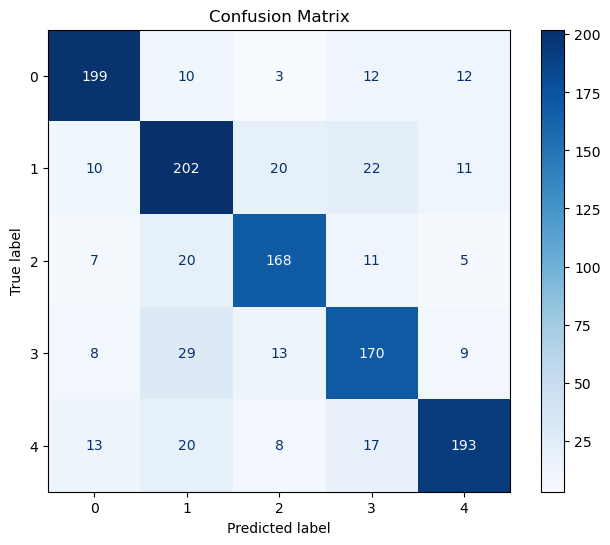

: 

In [ ]:
# Confusion Matrix for Model Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict the classes for the test set
pred_probs = ann_model.predict(x_test.toarray())
y_pred = pred_probs.argmax(axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()